In [852]:
import sys
import os
import numpy as np
from osgeo import ogr 
from collections import deque
import matplotlib.pyplot as plt


sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.gpkg import * 

ogr.UseExceptions()

In [853]:
ds = None 


In [854]:
layer_name = "weiche"

folder = "/media/riannek/minimax/gleis/"

ds = None 

import shutil 
file = shutil.copyfile(os.path.join(folder, "stage3vers.gpkg"), os.path.join(folder, "stage3tmp.gpkg"))

ds = ogr.Open(file, 1)

layers = []
for i in range(ds.GetLayerCount()):
    layer = ds.GetLayer(i)
    layers.append(layer.GetName())
layers.sort()
print(layers)

layer = ds.GetLayerByName(layer_name)

['TEMPLINELAYER', 'abseits', 'anfang weiche', 'kurve', 'viele', 'weiche']


In [855]:
def new_line_layer(ds, spatial_reference, logger):
    if layer_exists(ds, "centerlines"):
        delete_layer(ds, "centerlines", logger)
    layer = ds.CreateLayer("centerlines", spatial_reference, ogr.wkbLineString25D)
    return layer 


linelayer = new_line_layer(ds, layer.GetSpatialRef(), None)

def linelayer_add(layer, geom):
    feature = ogr.Feature(layer.GetLayerDefn())
    feature.SetGeometry(geom)
    layer.CreateFeature(feature)


In [856]:
def remove_points(fids, layer):
    """Remove points from the layer
    
    """
    if len(fids) == 0:
        return
    first = layer.GetFeature(fids[0])
    if first is None:
        # After reversing, the first point has already been removed
        fids = fids[1:]

    for fid in fids:
        layer.DeleteFeature(fid)

    layer.SyncToDisk()




def distance_points(point1, point2):
    return np.linalg.norm(point1 - point2)


def pruned_points(xyz):
    pruned_points = [] 
    offset = 0 # Keep reference of the index in the original xyz array
    N = len(xyz)

    while True:
        if len(xyz) < 2:
            # We have only one point left
            return pruned_points, offset

        distances = []
        for i in range(len(xyz)-1):
            distances.append(distance_points(xyz[i], xyz[i+1]))

        distances = np.array(distances)
        distances_cumsum = distances.cumsum()


        if distances_cumsum[0] > 1:
            # The second point is already far away from the first
            pruned_points.append(xyz[1])
            xyz = xyz[1:]
            offset += 1
            continue

        if distances_cumsum[-1] <= 1:
            # The last point is too close
            if offset == 0:
                # We seem to be at the start or end of the line
                # Add the first and last point
                pruned_points.append(xyz[0]) 
                pruned_points.append(xyz[-1]) 
                offset = N - 1
            return pruned_points, offset

        # Find the index of the last point that is less than 1 m away
        index = np.where(distances_cumsum < 1)[0][-1] + 1
        pruned_points.append(xyz[index])
        xyz = xyz[index:]
        offset += index




In [857]:
def get_all_points(layer):
    """Get all points from the layer as a list of numpy arrays"""
    points = []
    for feature in layer:
        geom = feature.GetGeometryRef()
        if geom is None:
            continue
        for i in range(geom.GetPointCount()):
            point = np.array(geom.GetPoint(i)[:3])
            points.append(point)

    layer.ResetReading()
    return np.array(points)

In [858]:
queue = deque()

In [859]:
np.rad2deg(np.arccos(0.99))

np.float64(8.109614455994183)

In [860]:
def distance_points_to_line(points, p0, direction):
    # Vectors from p0 to points
    v = points - p0

    # Line-to-point distance is norm of cross product over norm of direction
    cross = np.cross(v, direction)
    distances = np.linalg.norm(cross, axis=1) / np.linalg.norm(direction)
    return distances

def ransac_lines(points, threshold=0.1, min_inliers=3, max_iterations=20, max_lines=2):
    points = np.asarray(points)
    N = len(points)
    labels = np.full(N, -1)  # Initialize all as noise
    remaining_idx = np.arange(N)


    for current_label in range(max_lines):
        best_inliers = []

        for _ in range(max_iterations):
            if len(remaining_idx) < min_inliers:
                break
            sample_idx = np.random.choice(remaining_idx, 2, replace=False)
            p0, p1 = points[sample_idx]
            direction = p1 - p0

            # Direction not accurate if points are too close
            if np.linalg.norm(direction) < 0.1:
                continue

            distances = distance_points_to_line(points[remaining_idx], p0, direction)
            inliers = np.where(distances < threshold)[0]
            if len(inliers) > len(best_inliers):
                best_inliers = inliers

        if len(best_inliers) < min_inliers:
            break  # No more good lines

        inlier_global_idx = remaining_idx[best_inliers]
        labels[inlier_global_idx] = current_label

        # Remove inliers from remaining set
        remaining_idx = np.setdiff1d(remaining_idx, inlier_global_idx)

        if len(remaining_idx) < min_inliers:
            break

    return labels


In [861]:
def model_fitness(xyz, directions, labels=None):
    if labels is None:
        labels = np.zeros(len(xyz), dtype=int)
    fitness = np.zeros(len(xyz))

    for label in range(labels.max()+1):
        cluster = xyz[labels == label]
        # Set first points fitness to 1
        cluster_fitness = [1]

        for i in range(len(cluster)-1):
            cluster_fitness.append(model_fitness_score(cluster[i], cluster[i+1], directions[i]))

        cluster_fitness = np.array(cluster_fitness)
        fitness[labels == label] = cluster_fitness

    if len(fitness[fitness>0]) > 0:
        print("Min fitness:", fitness[fitness>0].min())
    return fitness


def model_fitness_score(point1, point2, direction):
    vector = point1 - point2
    vector = vector / np.linalg.norm(vector)
    direction = direction / np.linalg.norm(direction)
    return np.abs(direction @ vector)

In [862]:
class GrowingLine: 

    _id_counter = 0

    def __init__(self, head_fid, head_xyz, head_direction, head_gauge):
        self.head_fid = head_fid
        self.head_xyz = head_xyz
        self.head_direction = head_direction
        self.head_gauge = head_gauge

        self.start_xyz = head_xyz
        self.start_direction = head_direction
        self.start_gauge = head_gauge
        self.start_fid = head_fid

        self.switch = []
        self.in_switch = False

        self.points = [head_xyz]

        self.id = GrowingLine._id_counter
        GrowingLine._id_counter += 1

    @classmethod
    def from_feature(cls, feature):
        head_fid = feature.GetFID()
        head_xyz = np.array(feature.GetGeometryRef().GetPoint(0))
        head_direction = np.array([feature.GetField("eig x"), feature.GetField("eig y"), feature.GetField("eig z")])
        head_gauge = feature.GetField("gauge")
        return cls(head_fid, head_xyz, head_direction, head_gauge)




    def points_in_direction(self, layer, distance=10):
        """Read the points in the model direction and sort them
        
        """

        # Get a rectangular polygon for the spatial filter
        perpendicular = np.cross(self.head_direction, np.array([0, 0, 1]))
        scaled_direction = self.head_direction * distance

        ring = ogr.Geometry(ogr.wkbLinearRing)
        start = self.head_xyz + (perpendicular / 2)
        ring.AddPoint(start[0], start[1])
        pt = start + scaled_direction
        ring.AddPoint(pt[0], pt[1])
        pt = pt - perpendicular
        ring.AddPoint(pt[0], pt[1])
        pt = pt - scaled_direction
        ring.AddPoint(pt[0], pt[1])
        ring.AddPoint(start[0], start[1])
        geom = ogr.Geometry(ogr.wkbPolygon)
        geom.AddGeometry(ring)

        layer.SetSpatialFilter(geom)
        layer.ResetReading()

        xyz = [self.head_xyz]
        directions = [self.head_direction]
        gauges = [self.head_gauge]
        fids = [self.head_fid]
        distances = [0]

        for feature in layer:
            if feature.GetFID() == self.head_fid:
                continue
            xyz.append(np.array(feature.GetGeometryRef().GetPoint(0)))
            directions.append(np.array([feature.GetField("eig x"), feature.GetField("eig y"), feature.GetField("eig z")]))
            gauges.append(feature.GetField("gauge"))
            fids.append(feature.GetFID())

        layer.SetSpatialFilter(None)
        layer.ResetReading()
        
        for point in xyz[1:]:
            distances.append(np.linalg.norm(self.head_xyz - point))

        # Sort all lists by distance
        distances = np.array(distances)
        sorted_indices = np.argsort(distances)
        distances = distances[sorted_indices]
        xyz = np.array(xyz)[sorted_indices]
        directions = np.array(directions)[sorted_indices]
        gauges = np.array(gauges)[sorted_indices]
        fids = np.array(fids)[sorted_indices]

        return xyz, distances, directions, gauges, fids
    

    def add_switch(self, new_fid, head_xyz,  new_direction, gauge, points):


        if self.in_switch:
            # Update the head of the line
            switchline = self.switch[-1] 
            switchline.head_fid = new_fid
            switchline.head_xyz = head_xyz
            switchline.head_direction = new_direction
            switchline.head_gauge = gauge
            # Remove the first point if it is the same as the last point of the switch line
            if np.array_equal(switchline.points[-1], points[0]):
                points = points[1:]  
            switchline.points.extend(points)
        else:
            print("Adding new switch line")
            self.in_switch = True
            switchline = GrowingLine(
                new_fid, head_xyz, new_direction, gauge)
            switchline.points = points
            self.switch.append(switchline)


    def make_cut(self, bla=True):
        print("Making cut in switch")
        self.in_switch = False
        switchline = self.switch[-1]

        # Find the largest gap in the switch 
        distance_from_head = np.linalg.norm(switchline.head_xyz - self.head_xyz)
        length = np.linalg.norm(switchline.points[-1] - switchline.points[0])
        go_back = distance_from_head + length + 8

        distances = []
        reversed_points = self.points[::-1]
        cum_sum = 0
        
        for i in range(len(reversed_points)-1):
            distance = np.linalg.norm(reversed_points[i] - reversed_points[i+1])
            cum_sum += distance
            distances.append(distance)
            if cum_sum > go_back:
                break

        distances = np.array(distances)
        cut_index = np.argmax(distances) 
        print("Cut index:", cut_index, "distance", distances[cut_index], "go_back", go_back)

        # Cut the line
        self.points = reversed_points[:cut_index:-1]
        new_points = reversed_points[cut_index::-1]

        new_line = GrowingLine(
            self.head_fid,
            self.head_xyz,
            self.head_direction,
            self.head_gauge
        )
        new_line.points = new_points
        # New line doesn't need to be reversed
        new_line.start_fid = None
        self.switch.append(new_line)


    def reverse_head(self, active_line=True):
        """Reverse the head of the line
        
        """
        
        if self.start_fid is None:
            print("FINISHED")
            return False
        self.head_fid = self.start_fid
        self.head_xyz = self.start_xyz
        self.head_direction = -self.start_direction
        self.head_gauge = self.start_gauge
        self.points = self.points[::-1]
        
        if active_line:
            self.start_fid = None
        
        if self.in_switch:
            self.switch[-1].reverse_head(active_line=False)
        print("Reversed head")
        return True


    def get_linestring(self):
        """Get the linestring of the line
        
        """
        if len(self.points) == 0:
            return None
        geom = ogr.Geometry(ogr.wkbLineString25D)
        for point in self.points:
            geom.AddPoint(point[0], point[1], point[2])
        return geom

    def grow(self, layer, linelayer):
        while True:
            xyz, distances, directions, gauges, fids = self.points_in_direction(layer)
            if len(fids) < 3:
                # These are only 2 new points, not enough for a ransac line
                # Reverse head or stop if already reversed
                remove_points(fids, layer)
                if not self.reverse_head():
                    # If we can't reverse the head, we are done
                    break
                continue
            labels = ransac_lines(xyz, threshold=0.05, max_iterations=20)
            remove_points(fids[labels == -1], layer)
            max_label = labels.max()
            for label in range(max_label + 1):
                cluster = xyz[labels == label]
                if len(cluster) < 2:
                    continue
                try:
                    pruned, offset = pruned_points(cluster)
                except IndexError:
                    print("Error in pruned_points with cluster:", cluster)
                    print(len(cluster), "points")
                    raise IndexError("Pruned points failed")

                fids_cluster = fids[labels == label]

                remove_points(fids_cluster[:offset+1], layer)
                
                new_direction = directions[offset]
                if self.head_direction @ new_direction < 0:
                    new_direction = -new_direction

                if label == labels[0]:
                    # This is the active head
                    self.head_xyz = pruned[-1]
                    self.head_direction = new_direction
                    self.head_gauge = gauges[offset]
                    self.head_fid = fids_cluster[offset]
                    self.points.extend(pruned)
                else:
                    # This is the other rail in a switch (or false positive)
                    self.add_switch(fids_cluster[offset], pruned[-1], new_direction, gauges[offset], pruned)
            # Check if we reached the end of a switch
            if self.in_switch and max_label == 0:
                self.make_cut()
                if not self.reverse_head():
                    # If we can't reverse the head, we are done
                    break

        # Add the active line to the layer
        geom = self.get_linestring()
        if geom is not None and geom.GetPointCount() > 5:
            linelayer_add(linelayer, geom)

        return self.switch
    
    def __repr__(self):
        return f"GrowingLine(id={self.id}, head_fid={self.head_fid}, points={len(self.points)})"

## Start

In [863]:
all_points = get_all_points(layer)

In [864]:

layer.GetFeatureCount()

3882

In [865]:
feature = layer.GetNextFeature()
feature

OGRFeature(weiche):951
  eig x (Real) = 0.206159349714193
  eig y (Real) = -0.978518279550064
  eig z (Real) = -0.000546911147630067
  gauge (Real) = 1.44567067823869
  min points (Integer) = 300
  POINT Z (4473849.34625483 5336264.62714754 516.615297792815)


In [866]:
active_line = GrowingLine.from_feature(feature)


## Ab hier muss dann Schleife

In [936]:
xyz, distances, directions, gauges, fids = active_line.points_in_direction(layer)
print(len(xyz))

47


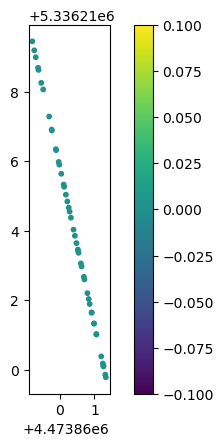

In [937]:
labels = ransac_lines(xyz, threshold=0.05, max_iterations=20)

x = xyz[:, 0]
y = xyz[:, 1]

fig, ax = plt.subplots()
sc = ax.scatter(x, y, c=labels, cmap='viridis', s=10)
plt.colorbar(sc)
#equal aspect ratio
ax.set_aspect('equal', adjustable='box')


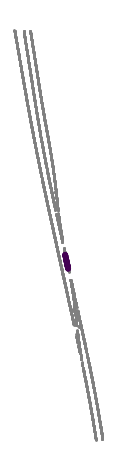

In [938]:
fig, ax = plt.subplots()
ax.scatter(all_points[:, 0], all_points[:, 1], c='gray', s=1)
ax.scatter(x, y, c=labels, cmap='viridis', s=10)
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()
fig.tight_layout()
fig.savefig("current_ransac_lines.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [939]:
for label in range(labels.max()+1):
    cluster = xyz[labels == label]
    pruned, offset = pruned_points(cluster)
    fids_cluster = fids[labels == label]

    remove_points(fids_cluster[:offset+1], layer)
    
    new_direction = directions[offset]
    if active_line.head_direction @ new_direction < 0:
        new_direction = -new_direction

    
    
    if label == labels[0]:
        # This is the active head 
        active_line.head_xyz = pruned[-1]
        active_line.head_direction = new_direction
        active_line.head_gauge = gauges[offset]
        active_line.head_fid = fids_cluster[offset]
        active_line.points.extend(pruned) 
        print(len(pruned), "points added to active line")
    else:
        # This is the other rail in a switch (or false positive)
        active_line.add_switch(fids_cluster[offset], pruned[-1], new_direction, gauges[offset], pruned)
        print(len(pruned), "points added to switch line")

# Check if we reached the end of a switch
if active_line.in_switch and labels.max() == 0:
    print("must_cut")
    must_cut = True
    # active_line.make_cut()
    # if not active_line.reverse_head():
    #     # If we can't reverse the head, we are done
    #     print("Finished growing line")
else:
    must_cut=False

11 points added to active line
must_cut


In [940]:
print("active line points:", len(active_line.points))
print("switch lines:", len(active_line.switch))
for i, switch in enumerate(active_line.switch):
    print(f"Switch line {i} points:", len(switch.points))

active line points: 61
switch lines: 1
Switch line 0 points: 11


In [941]:
active_line.in_switch 

True

In [942]:
active_line.id

0

In [943]:
active_line.switch

[GrowingLine(id=1, head_fid=87398, points=11)]

In [944]:
offset 

np.int64(41)

In [945]:
active_line.head_xyz

array([4.47386120e+06, 5.33621039e+06, 5.16765840e+02])

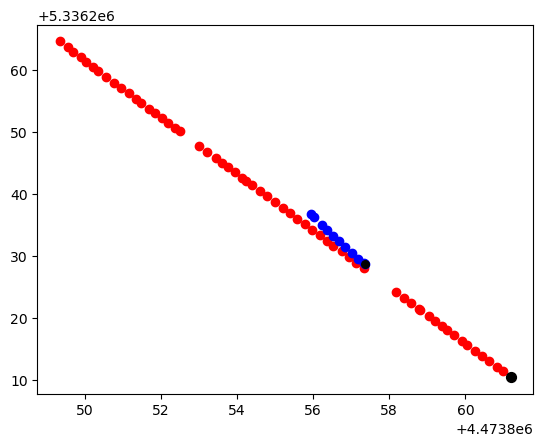

In [946]:
fig, ax = plt.subplots()

active = np.array(active_line.points) 

ax.scatter(active[:, 0], active[:, 1], c='red')

colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink']

for i, switch in enumerate(active_line.switch):
    points = np.array(switch.points)
    ax.scatter(points[:, 0], points[:, 1], c=colors[i % len(colors)])
    ax.scatter(switch.head_xyz[0], switch.head_xyz[1], c='black', s=30, label='Head')

ax.scatter(active_line.head_xyz[0], active_line.head_xyz[1], c='black', s=50, label='Head')

In [947]:
switchline = active_line.switch[-1]
between_heads = active_line.head_xyz - switchline.head_xyz
print(np.linalg.norm(between_heads))
print((between_heads) @ active_line.head_direction)

18.609352078665058
18.608331742539484


In [948]:
switchline.head_fid  

np.int64(87398)

In [949]:
switchline.start_fid

np.int64(87372)

## STOP HERE

In [950]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
active_line.make_cut()
if not active_line.reverse_head():
    # If we can't reverse the head, we are done
    print("Finished growing line")

Making cut in switch
Cut index: 22 distance 5.718684087325809 go_back 25.313602615966573
FINISHED
Finished growing line


In [ ]:
active_line.reverse_head()

FINISHED


False

In [ ]:
queue.extend(active_line.switch)
print(len(queue))
active_line = queue.pop()
print("Active line:", active_line)

3
Active line: GrowingLine(id=4, head_fid=213630, points=23)


In [ ]:
geom = active_line.get_linestring()
print(geom.Length())

if geom.Length() > 5:
    linelayer_add(linelayer, geom)


6.5373792594158795


In [ ]:
ds = None

In [ ]:
print(len(active_line.switch))

1


In [ ]:
active_line.points

[array([4.47384935e+06, 5.33626463e+06, 5.16615298e+02]),
 array([4.47384955e+06, 5.33626366e+06, 5.16617102e+02]),
 array([4.47384969e+06, 5.33626298e+06, 5.16619140e+02]),
 array([4.47384989e+06, 5.33626206e+06, 5.16621711e+02]),
 array([4.47385004e+06, 5.33626134e+06, 5.16624717e+02]),
 array([4.47385021e+06, 5.33626051e+06, 5.16628995e+02]),
 array([4.47385036e+06, 5.33625985e+06, 5.16633380e+02]),
 array([4.47385056e+06, 5.33625890e+06, 5.16641226e+02]),
 array([4.47385077e+06, 5.33625794e+06, 5.16648073e+02]),
 array([4.47385094e+06, 5.33625716e+06, 5.16652350e+02]),
 array([4.47385115e+06, 5.33625621e+06, 5.16657833e+02]),
 array([4.47385134e+06, 5.33625536e+06, 5.16661790e+02])]

In [ ]:
active_line.head_fid

1103

In [ ]:
active_line.head_xyz

array([4.47385134e+06, 5.33625536e+06, 5.16661790e+02])

In [ ]:
active_line.switch 

In [ ]:
active_line.switch[0].head_fid  

87372

In [ ]:
active_line.switch[1].head_fid  

87394

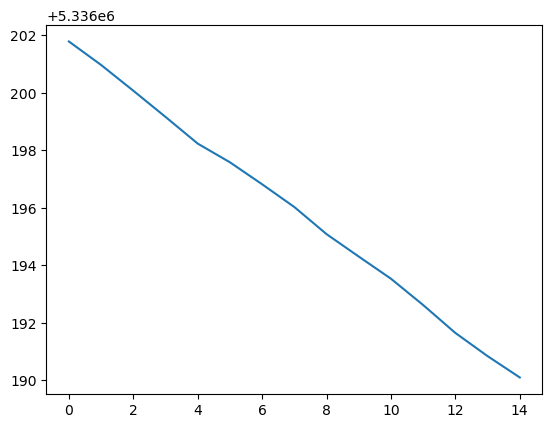

In [ ]:
foo = np.array(active_line.points)
foo = foo[:,1] 
x = np.arange(len(foo))
fig, ax = plt.subplots()
ax.plot(x, foo)

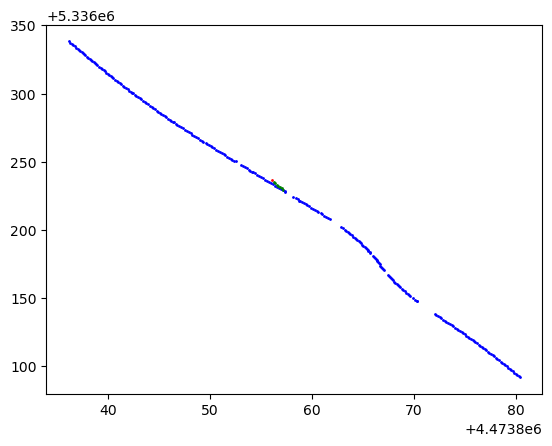

In [ ]:
fig, ax = plt.subplots()
foo = np.array(active_line.points)
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

foo = np.array(active_line.switch[0].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='r', s=1)

foo = np.array(active_line.switch[1].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='g', s=1)

foo = np.array(active_line.switch[2].points)  
x = foo[:,0]
y = foo[:,1]
ax.scatter(x, y, c='b', s=1)

In [ ]:
remove_points([feature.GetFID()], layer)